# Bibliotecas e utilidades

In [1]:
!pip install python-bcb

In [2]:
from bcb import sgs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from plotnine import *
import statsmodels.api as sm

In [3]:
# Cores para gráficos
colors = {'blue': '#282f6b',
          'red'   : "#b22200",
          'green': '#224f20',
          'purple' : "#5f487c",
          'gray': '#666666',
          'orange' : '#b35c1e'
          }

# Coleta de dados

In [4]:
# Importa os dados
nucleos_df = sgs.get({'ex0' : 11427, 'ex3' : 27839, 'dp' : 16122, 'ms' : 4466, 'p55' : 28750, 'ipca' : 433}, start = '2002-01-01')

# Tratamento dos dados

In [5]:
# Define df do nucleos
nucleos = nucleos_df.copy()

# Calcula a média dos núcleos
nucleos['media_nucleos'] = nucleos.drop('ipca', axis = 1).mean(axis=1)

# Obter o nome do mês
nucleos['mes'] = nucleos.index.month_name()

# Calcular a media para cada mês
media_m = nucleos.groupby('mes')['media_nucleos'].mean()

# Calcular o percentil 20 e 80 para cada mês
percentil_20 = nucleos.groupby('mes')['media_nucleos'].quantile(0.2)
percentil_80 = nucleos.groupby('mes')['media_nucleos'].quantile(0.8)

# Criar um DataFrame com os resultados
resultados = pd.DataFrame({
    'mes' : media_m.index,
    'media_m': media_m.values,
    'percentil_20': percentil_20.values,
    'percentil_80': percentil_80.values
})

# Obtém valores do ano atual
nucleos_m = (nucleos
 .query('index >= "2024-01-01"')
 .reset_index()
 [['mes', 'media_nucleos', 'ipca']]
)

# Junta os resultados
df_nucleos = pd.merge(left = resultados, right = nucleos_m, how = 'outer')
df_nucleos

,mes,media_m,percentil_20,percentil_80,media_nucleos,ipca
0,April,0.497826,0.3016,0.6444,0.264,0.38
1,August,0.387545,0.2296,0.5032,NaN,NaN
2,December,0.616364,0.4076,0.7096,NaN,NaN
3,February,0.558087,0.3684,0.7292,0.496,0.83
4,January,0.574261,0.4224,0.6936,0.426,0.42
5,July,0.349818,0.1824,0.5112,NaN,NaN
6,June,0.412636,0.2588,0.5616,NaN,NaN
7,March,0.475826,0.2728,0.6580,0.154,0.16
8,May,0.487636,0.2880,0.6480,NaN,NaN
9,November,0.463636,0.2536,0.5960,NaN,NaN


In [6]:
# Obter a lista de todos os meses presentes nos dados e ordená-los
ordem_meses = sorted(df_nucleos['mes'].unique(), key=lambda x: pd.to_datetime(x, format='%B'))

# Ordenar os dados de acordo com a ordem dos meses
df_nucleos['mes'] = pd.Categorical(df_nucleos['mes'], categories=ordem_meses, ordered=True)
df_nucleos = df_nucleos.sort_values(by='mes')

# Cortar os valores da coluna 'mes'
df_nucleos['mes'] = df_nucleos['mes'].str.slice(stop=3)

df_nucleos

,mes,media_m,percentil_20,percentil_80,media_nucleos,ipca
4,Jan,0.574261,0.4224,0.6936,0.426,0.42
3,Feb,0.558087,0.3684,0.7292,0.496,0.83
7,Mar,0.475826,0.2728,0.6580,0.154,0.16
0,Apr,0.497826,0.3016,0.6444,0.264,0.38
8,May,0.487636,0.2880,0.6480,NaN,NaN
6,Jun,0.412636,0.2588,0.5616,NaN,NaN
5,Jul,0.349818,0.1824,0.5112,NaN,NaN
1,Aug,0.387545,0.2296,0.5032,NaN,NaN
11,Sep,0.413545,0.2792,0.5692,NaN,NaN
10,Oct,0.489000,0.3148,0.5800,NaN,NaN


# Análise dos dados

## Variação Mensal do Núcleo

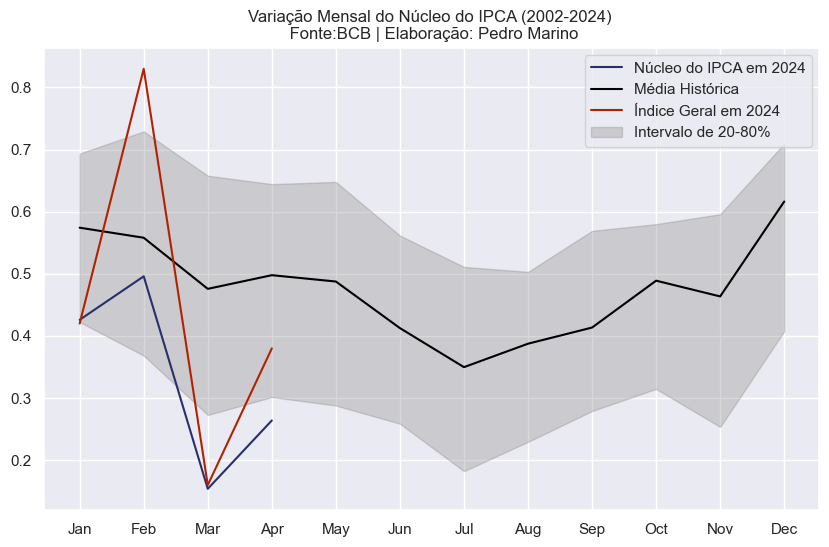

In [32]:
# Configurar o estilo do seaborn
sns.set()

# Definir o tamanho da figura
plt.figure(figsize=(10, 6))  # Ajuste a largura e altura conforme necessário

# Plotar as linhas
sns.lineplot(data=df_nucleos, x='mes', y='media_nucleos', color='#282f6b', label='Núcleo do IPCA em 2024')
sns.lineplot(data=df_nucleos, x='mes', y='media_m', color='black', label='Média Histórica')
sns.lineplot(data=df_nucleos, x='mes', y='ipca', color='#b22200', label='Índice Geral em 2024')

# Preencher a área entre os percentis 20 e 80
plt.fill_between(df_nucleos['mes'], df_nucleos['percentil_20'], df_nucleos['percentil_80'], color='grey', alpha=0.3, label='Intervalo de 20-80%')

# Adicionar legenda
plt.legend()

# Remover os nomes dos eixos x e y
plt.title('Variação Mensal do Núcleo do IPCA (2002-2024) \n Fonte:BCB | Elaboração: Pedro Marino')
plt.xlabel(None)
plt.ylabel(None)

# Exibir o gráfico
plt.show()

## Variação Acumulada e SAAR

In [8]:
# Função para acumular valores em janelas móveis
def acum_p(data, n):
    """
    Calcula a acumulação de variações percentuais em janelas móveis.

    Argumentos:
    - data: array-like
        Uma sequência de dados representando variações percentuais.

    - n: int
        O tamanho da janela móvel para o cálculo da acumulação.

    Retorno:
    - array
        Um array contendo a acumulação das variações percentuais em janelas móveis.
    """

    resultado = (((data / 100) + 1)
                 .rolling(window=  n)
                 .apply(np.prod)
                 - 1) * 100

    return resultado

In [9]:
# Realiza a decomposição (aditiva)
decomposition = sm.tsa.seasonal_decompose(nucleos.media_nucleos, model = 'additive')

nucleos['nucleos_sa'] = nucleos.media_nucleos.values - decomposition.seasonal.values

In [10]:
# Calcula Acumulado e Média Móvel
dados = (
    nucleos
    .assign(nucleos_12m = lambda x: acum_p(x.media_nucleos, n = 12), # acumula em 12 meses
            nucleos_mm3m = lambda x: x.nucleos_sa.rolling(window = 3).mean() * 12 # média móvel de 3 meses e anualiza
    )
    .reset_index()
    .dropna()
)

dados

,Date,ex0,ex3,dp,ms,p55,ipca,media_nucleos,mes,nucleos_sa,nucleos_12m,nucleos_mm3m
11,2002-12-01,1.66,1.84,1.75,1.36,1.74,2.10,1.670,December,1.533291,9.064519,15.364662
12,2003-01-01,1.38,1.46,1.84,1.32,1.71,2.25,1.542,January,1.444827,10.169009,17.956892
13,2003-02-01,0.99,0.62,1.35,0.93,0.69,1.57,0.916,February,0.839886,10.565623,15.272019
14,2003-03-01,1.13,1.36,1.20,1.23,0.89,1.23,1.162,March,1.157506,11.251861,13.768876
15,2003-04-01,0.81,0.99,0.98,1.10,0.81,0.97,0.938,April,0.912200,11.705598,11.638368
...,...,...,...,...,...,...,...,...,...,...,...,...
263,2023-12-01,0.47,0.46,0.43,0.47,0.42,0.56,0.450,December,0.313291,4.344601,3.036662
264,2024-01-01,0.16,0.61,0.45,0.51,0.40,0.42,0.426,January,0.328827,4.251173,3.356892
265,2024-02-01,0.73,0.28,0.53,0.42,0.52,0.83,0.496,February,0.419886,4.008993,4.248019
266,2024-03-01,0.01,0.21,0.16,0.24,0.15,0.16,0.154,March,0.149506,3.787230,3.592876


In [22]:
# Transforma de wide para long
dados_long = dados[['Date', 'nucleos_12m', 'nucleos_mm3m']].melt(id_vars = ['Date'])


In [23]:
dados_long

,Date,variable,value
0,2002-12-01,nucleos_12m,9.064519
1,2003-01-01,nucleos_12m,10.169009
2,2003-02-01,nucleos_12m,10.565623
3,2003-03-01,nucleos_12m,11.251861
4,2003-04-01,nucleos_12m,11.705598
...,...,...,...
509,2023-12-01,nucleos_mm3m,3.036662
510,2024-01-01,nucleos_mm3m,3.356892
511,2024-02-01,nucleos_mm3m,4.248019
512,2024-03-01,nucleos_mm3m,3.592876


In [20]:
variables = dados_long["variable"].unique()
variables

array(['nucleos_12m', 'nucleos_mm3m'], dtype=object)

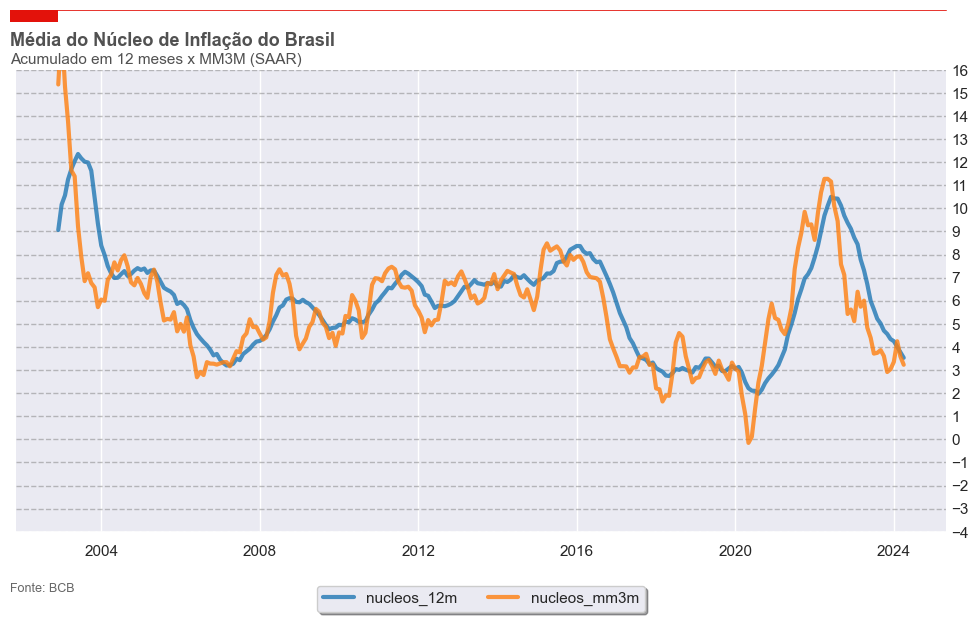

In [31]:
# Setup plot size.
fig, ax = plt.subplots(figsize=(12, 6))

# Loop through country names and plot each one with a different color.
for i, variable in enumerate(variables):
    color = plt.cm.tab10(i)  # Use a different color for each variable
    ax.plot(dados_long[dados_long['variable'] == variable]['Date'],
            dados_long[dados_long['variable'] == variable]['value'],
            color=color,
            alpha=0.8,
            linewidth=3,
            label=variable)  # Add label for legend

# Add legend below the plot.
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), shadow=True, ncol=len(variables))

######### Estética do Gráfico #########
# Remove splines. Can be done one at a time or can slice with a list.
ax.spines[['top', 'right', 'left']].set_visible(False)

# Shrink y-lim to make plot a bit tighter
ax.set_ylim(-4, 16)

# Reformat x-axis tick labels
ax.xaxis.set_tick_params(labelsize=11)

# Reformat y-axis tick labels and add grid lines
ax.set_yticks(np.arange(-4, 17, 1))  # Set y-ticks at intervals of 1
ax.yaxis.grid(True, linestyle='--', which='major', color='gray', alpha=0.5)  # Add grid lines for y-axis

ax.yaxis.set_tick_params(pad=-2, labeltop=True, labelbottom=False, bottom=False, labelsize=11)

# Add in line and tag
ax.plot([0.12, .9], [.98, .98], transform=fig.transFigure, clip_on=False, color='#E3120B', linewidth=.6)
ax.add_patch(plt.Rectangle((0.12, .98), 0.04, -0.02, facecolor='#E3120B', transform=fig.transFigure, clip_on=False, linewidth=0))

# Add in title and subtitle
ax.text(x=0.12, y=.92, s="Média do Núcleo de Inflação do Brasil", transform=fig.transFigure, ha='left', fontsize=13, weight='bold', alpha=.8)
ax.text(x=0.12, y=.89, s="Acumulado em 12 meses x MM3M (SAAR)", transform=fig.transFigure, ha='left', fontsize=11, alpha=.8)

# Set source text
ax.text(x=0.12, y=0.01, s="""Fonte: BCB""", transform=fig.transFigure, ha='left', fontsize=9, alpha=.7)

plt.show()